# 모델링

In [2]:
from sklearn.externals import joblib
import keras
from keras import models
from keras import layers
import model_evaluation_utils as meu
import matplotlib.pyplot as plt

%matplotlib inline

_이전에 추출한 특성을 가져옵니다. VGG모델에서 얻은 2048 1차원 벡터입니다.._

In [3]:
train_features = joblib.load('train_tl_features.pkl')
train_labels = joblib.load('train_labels.pkl')
validation_features = joblib.load('validate_tl_features.pkl')
validation_labels = joblib.load('validate_labels.pkl')
test_features = joblib.load('test_tl_features.pkl')
test_labels = joblib.load('test_labels.pkl')

train_features.shape, validation_features.shape, test_features.shape

((18300, 2048), (6100, 2048), (6100, 2048))

In [4]:
train_labels.shape, validation_labels.shape, test_labels.shape

((18300,), (6100,), (6100,))

_딥러닝 모델에 넣기 위해 라벨을 원-핫 인코딩으로 변환을 합니다._

In [5]:
from keras.utils import to_categorical

train_labels_ohe = to_categorical(train_labels)
validation_labels_ohe = to_categorical(validation_labels)
test_labels_ohe = to_categorical(test_labels)

In [6]:
train_labels_ohe.shape, validation_labels_ohe.shape, test_labels_ohe.shape

((18300, 10), (6100, 10), (6100, 10))

_sequential 모델을 생성합니다._

In [7]:
model = models.Sequential()
model.add(layers.Dense(1024, activation='relu', input_shape=(train_features.shape[1],)))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(train_labels_ohe.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',                 
                      metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)              

_배치사이즈 128에 에포크 50으로 학습을 시작합니다._

In [8]:
history = model.fit(train_features,
                    train_labels_ohe,
                    epochs=50,
                    batch_size=128,
                    validation_data=(validation_features, validation_labels_ohe), 
                    shuffle=True,
                    verbose=1)

Train on 18300 samples, validate on 6100 samples
Epoch 1/50
18300/18300 [==============================] - 10s 547us/step - loss: 2.3430 - accuracy: 0.4010 - val_loss: 1.0612 - val_accuracy: 0.6507
Epoch 2/50
18300/18300 [==============================] - 9s 497us/step - loss: 1.1698 - accuracy: 0.6034 - val_loss: 0.8237 - val_accuracy: 0.7331
Epoch 3/50
18300/18300 [==============================] - 8s 463us/step - loss: 0.9572 - accuracy: 0.6871 - val_loss: 0.7279 - val_accuracy: 0.7713
Epoch 4/50
18300/18300 [==============================] - 9s 465us/step - loss: 0.8289 - accuracy: 0.7298 - val_loss: 0.6828 - val_accuracy: 0.7946
Epoch 5/50
18300/18300 [==============================] - 9s 470us/step - loss: 0.7680 - accuracy: 0.7553 - val_loss: 0.6422 - val_accuracy: 0.8049
Epoch 6/50
18300/18300 [==============================] - 9s 469us/step - loss: 0.6895 - accuracy: 0.7764 - val_loss: 0.5944 - val_accuracy: 0.8175
Epoch 7/50
18300/18300 [==============================] - 9s 4

_분류기 성능 평가 : 테스트 데이터로 예측값을 만듭니다._

In [10]:
predictions = model.predict_classes(test_features)

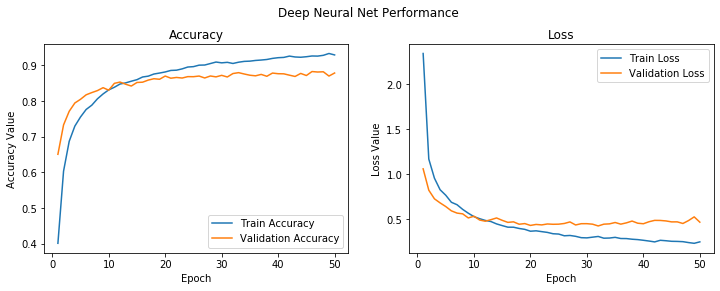

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.2)

epochs = list(range(1,51))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

_모델 데이터의 성을을 평가하기 위해 데이터를 변경합니다._

In [12]:
class_map = {'0' : 'air_conditioner', '1' : 'car_horn', '2' : 'children_playing', '3' : 'dog_bark', '4' : 'drilling', 
             '5' : 'engine_idling', '6' : 'gun_shot', '7' : 'jackhammer', '8' : 'siren', '9' : 'street_music'}

test_labels_categories = [class_map[str(label)] for label in test_labels]
prediction_labels_categories = [class_map[str(label)] for label in predictions]
category_names = list(class_map.values())

_사이킷런의 metrics를 사용하여 성능을 평가합니다._

In [13]:
meu.get_metrics(true_labels=test_labels_categories, 
                predicted_labels=prediction_labels_categories)

Accuracy: 0.8757
Precision: 0.877
Recall: 0.8757
F1 Score: 0.8758


_카테고리별로 확인을 할 수 있습니다._

In [14]:
meu.display_classification_report(true_labels=test_labels_categories, 
                                  predicted_labels=prediction_labels_categories, 
                                  classes=category_names)

                  precision    recall  f1-score   support

 air_conditioner       0.88      0.95      0.91       783
        car_horn       0.88      0.84      0.86       190
children_playing       0.78      0.82      0.80       845
        dog_bark       0.88      0.80      0.83       598
        drilling       0.92      0.89      0.90       683
   engine_idling       0.93      0.92      0.92       733
        gun_shot       0.91      0.97      0.94        60
      jackhammer       0.92      0.95      0.93       663
           siren       0.94      0.91      0.92       757
    street_music       0.80      0.79      0.79       788

        accuracy                           0.88      6100
       macro avg       0.88      0.88      0.88      6100
    weighted avg       0.88      0.88      0.88      6100



In [17]:
meu.display_confusion_matrix_pretty(true_labels=test_labels_categories, 
                                    predicted_labels=prediction_labels_categories, 
                                    classes=category_names)

/Users/maguire1815/Documents/saturday_speech/hands-on-transfer-learning-with-python-chapter-8/model_evaluation_utils.py:76: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  columns=pd.MultiIndex(levels=[['Predicted:'], classes],
/Users/maguire1815/Documents/saturday_speech/hands-on-transfer-learning-with-python-chapter-8/model_evaluation_utils.py:78: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  index=pd.MultiIndex(levels=[['Actual:'], classes],


_모델을 저장합니다._

In [18]:
model.save('sound_classification_model.h5') 